Intro:

In the following task, we complete the workflow according to the requirements.

The data cleaning method is `winsor`, which replaces the observation beyond 1st and 99th percentiles with the respective percentile values.

Then as an additional task, we implement `cross-validation` to compare the three methods.

# A. Selenium

### Housing Rent

In [89]:
from selenium import webdriver
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import statsmodels.api as sm
from patsy.build import build_design_matrices
from patsy.highlevel import dmatrices
from sklearn.model_selection import KFold
from typing import List, Dict, Tuple
import os


In [24]:
print(plt.style.available)
%matplotlib inline
driver = webdriver.Chrome()
url='https://esf.fang.com/house-a015277-b03115/'
driver.get(url)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [25]:
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

driver.get(url)
string_list = []
i = 0
Num_Pages = 20

while i < Num_Pages:
    table = driver.find_element('class name', 'houseList')
    string_list.append(table.get_attribute('outerHTML'))  # Collect raw HTML
    try:
        fanye_div = driver.find_element(By.CLASS_NAME, 'fanye')
        links = fanye_div.find_elements(By.TAG_NAME, 'a')
        for link in links:
            if link.text.strip() == '下一页':
                link.click()
                break
        i += 1
    except NoSuchElementException:
        break


In [26]:
# process the website of clearfix structure, using BeautifulSoup
all_data = []
for html in string_list:
    soup = BeautifulSoup(html, 'html.parser')
    infos = soup.find_all('dd', class_='info rel')
    for info in infos:
        all_text = info.get_text(separator=' ', strip=True)
        all_data.append([all_text])

df_full = pd.DataFrame(all_data, columns=['info'])

driver.quit()

In [27]:

def extract_area(text):
    if isinstance(text, str):
        match = re.search(r'(\d+\.?\d*)㎡', text)
        return float(match.group(1)) if match else None
    return None

def extract_price(text):
    if isinstance(text, str):
        match = re.search(r'(\d+\.?\d*)\s*元/月', text)
        return float(match.group(1)) if match else None
    return None

df_final = pd.DataFrame({
    'area': df_full['info'].apply(extract_area),
    'rent': df_full['info'].apply(extract_price)
})

In [28]:
df_final.describe()
df_final.to_parquet("shijichengrent.parquet", index=False)

### Housing Price

In [29]:

print(plt.style.available)
%matplotlib inline
driver = webdriver.Chrome()

url='https://esf.fang.com/house-a015277-b03115/'
driver.get(url)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [30]:
driver.get(url)
string_list = []
i = 0
Num_Pages = 20

while i < Num_Pages:
    table = driver.find_element('class name', 'shop_list.shop_list_4')
    string_list.append(table.get_attribute('outerHTML'))    # Collect raw HTML
    try:
        next_page = driver.find_element('class name', 'last')
        next_page.click()
        i += 1
    except NoSuchElementException:
        break

# process the website of clearfix structure, using BeautifulSoup
all_data = []
for html in string_list:
    soup = BeautifulSoup(html, 'html.parser')
    dls = soup.find_all('dl', class_='clearfix')
    for dl in dls:
        all_text = dl.get_text(separator=' ', strip=True)
        all_data.append([all_text])

df_full = pd.DataFrame(all_data, columns=['info'])

driver.quit()

In [31]:
# Extract area and price
def extract_area(text):
    if isinstance(text, str):
        match = re.search(r'(\d+\.?\d*)㎡', text)
        return float(match.group(1)) if match else None
    return None

def extract_price(text):
    if isinstance(text, str):
        matches = list(re.finditer(r'(\d+\.?\d*)\s*万', text))
        if matches:
            return float(matches[-1].group(1))
    return None

df_final = pd.DataFrame({
    'area': df_full['info'].apply(extract_area),
    'price': df_full['info'].apply(extract_price)
})

df_final.to_parquet("shijichengprice.parquet", index=False)

# 3.3 Data Analysis

### Data Analysis

In [34]:
rent_df = pd.read_parquet('shijichengrent.parquet')
price_df = pd.read_parquet('shijichengprice.parquet')

# Data description
print("Rent Data Description:")
print(rent_df.describe())
print("\nPrice Data Description:")
print(price_df.describe())


Rent Data Description:
               rent         area
count   1200.000000  1200.000000
mean   19237.050000   157.127500
std    10362.841955    47.598539
min     7500.000000    57.000000
25%    13000.000000   125.000000
50%    16000.000000   161.000000
75%    21000.000000   175.000000
max    70000.000000   323.000000

Price Data Description:
             price         area
count  1200.000000  1200.000000
mean   1911.776667   165.542650
std     809.624228    51.861275
min     377.000000    56.990000
25%    1400.000000   130.000000
50%    1780.000000   165.000000
75%    2200.000000   193.500000
max    8000.000000   494.340000


In [36]:
# Outlier detection functions using Z-score methods
def zscore_outlier_mask(s, thr=3.0):    # Z-score threshold: 3 times of std
    mu, sd = s.mean(), s.std(ddof=0)
    z = (s - mu) / sd
    return z.abs() > thr

# Mark outliers for rent
rent_df['area_z_outlier'] = zscore_outlier_mask(rent_df['area'])
rent_df['rent_z_outlier'] = zscore_outlier_mask(rent_df['rent'])

print("\nRent Outlier Counts:")
print("Area Z-score:", rent_df['area_z_outlier'].sum())
print("Rent Z-score:", rent_df['rent_z_outlier'].sum())

# Mark outliers for price
price_df['area_z_outlier'] = zscore_outlier_mask(price_df['area'])
price_df['price_z_outlier'] = zscore_outlier_mask(price_df['price'])

print("\nPrice Outlier Counts:")
print("Area Z-score:", price_df['area_z_outlier'].sum())
print("Price Z-score:", price_df['price_z_outlier'].sum())


Rent Outlier Counts:
Area Z-score: 11
Rent Z-score: 42

Price Outlier Counts:
Area Z-score: 16
Price Z-score: 28


###  Price Rent Ratio

In [37]:
blocks = ['shijicheng', 'beitaipingzhuang', 'wanliu', 'suzhouqiao']
price_files = [f'{block}price.parquet' for block in blocks]
rent_files  = [f'{block}rent.parquet'  for block in blocks]

dfs = []

# Process price files
for block, file in zip(blocks, price_files):
    df = pd.read_parquet(file)
    df['block'] = block
    df['price_per_m2'] = df['price'] / df['area']
    dfs.append(df)

# Process rent files
for block, file in zip(blocks, rent_files):
    df = pd.read_parquet(file)
    df['block'] = block
    df['rent_per_m2'] = df['rent'] / df['area']
    dfs.append(df)


    price    area       block  price_per_m2
0  1546.0  172.34  shijicheng      8.970639
1  1060.0  107.00  shijicheng      9.906542
2  2100.0  209.00  shijicheng     10.047847
3  1020.0   86.30  shijicheng     11.819235
4  1350.0  166.00  shijicheng      8.132530
   price   area             block  price_per_m2
0  598.0  81.07  beitaipingzhuang      7.376341
1  286.0  33.15  beitaipingzhuang      8.627451
2  760.0  93.49  beitaipingzhuang      8.129212
3  675.0  74.50  beitaipingzhuang      9.060403
4  930.0  95.15  beitaipingzhuang      9.774041
    price    area   block  price_per_m2
0  8500.0  395.00  wanliu     21.518987
1  2280.0  188.15  wanliu     12.117991
2  2400.0  114.59  wanliu     20.944236
3  4300.0  305.08  wanliu     14.094664
4  7000.0  420.21  wanliu     16.658337
   price   area       block  price_per_m2
0  720.0  91.28  suzhouqiao      7.887818
1  480.0  58.70  suzhouqiao      8.177172
2  398.0  56.70  suzhouqiao      7.019400
3  398.0  56.70  suzhouqiao      7.01940

In [66]:
# 1) Data description for each block, any outliers?
def zscore_outlier_mask(s, thr=3.0):
    mu, sd = s.mean(), s.std(ddof=0)
    z = (s - mu) / sd
    return z.abs() > thr

for block, pf, rf in zip(blocks, price_files, rent_files):
    price_df = pd.read_parquet(pf)
    rent_df  = pd.read_parquet(rf)

    print(f"--- Block: {block} ---")

    # Price Data Analysis
    print("\nPrice Data Description:")
    print(price_df[['price', 'area']].describe())

    area_outliers = zscore_outlier_mask(price_df['area']).sum()
    price_outliers = zscore_outlier_mask(price_df['price']).sum()
    print(f"Price Data Outliers (Z-score > 3):")
    print(f"  - Area: {area_outliers} outliers")
    print(f"  - Price: {price_outliers} outliers")

    # Rent Data Analysis
    print("\nRent Data Description:")
    print(rent_df[['rent', 'area']].describe())

    area_outliers = zscore_outlier_mask(rent_df['area']).sum()
    rent_outliers = zscore_outlier_mask(rent_df['rent']).sum()
    print(f"Rent Data Outliers (Z-score > 3):")
    print(f"  - Area: {area_outliers} outliers")
    print(f"  - Rent: {rent_outliers} outliers\n")


--- Block: shijicheng ---

Price Data Description:
             price         area
count  1200.000000  1200.000000
mean   1911.776667   165.542650
std     809.624228    51.861275
min     377.000000    56.990000
25%    1400.000000   130.000000
50%    1780.000000   165.000000
75%    2200.000000   193.500000
max    8000.000000   494.340000
Price Data Outliers (Z-score > 3):
  - Area: 16 outliers
  - Price: 28 outliers

Rent Data Description:
               rent         area
count   1200.000000  1200.000000
mean   19237.050000   157.127500
std    10362.841955    47.598539
min     7500.000000    57.000000
25%    13000.000000   125.000000
50%    16000.000000   161.000000
75%    21000.000000   175.000000
max    70000.000000   323.000000
Rent Data Outliers (Z-score > 3):
  - Area: 11 outliers
  - Rent: 42 outliers

--- Block: beitaipingzhuang ---

Price Data Description:
             price        area
count   452.000000  452.000000
mean   1047.011062  128.986726
std     753.613072   91.497687


Median Price-to-Rent Ratio (Investment Return Period in Years):
              block  price_rent_ratio_years
0  beitaipingzhuang               51.334644
1        shijicheng               85.460005
2        suzhouqiao               54.031145
3            wanliu               80.629791


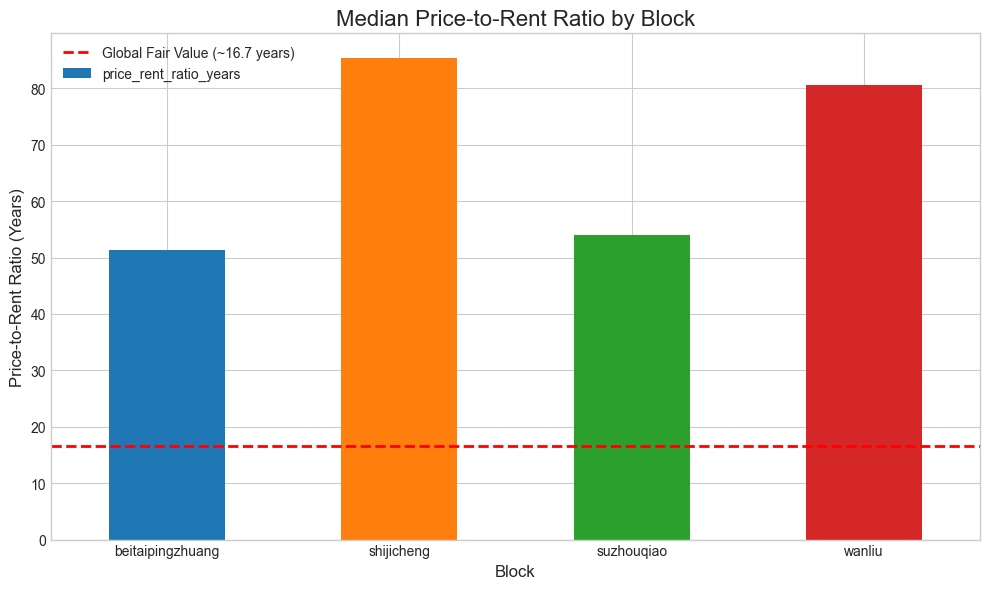

In [41]:
# 2) Calculate median price to rent ratio for each block

# --- Consolidate Data ---
all_prices_list = []
for block in blocks:
    df = pd.read_parquet(f'{block}price.parquet')
    df['block'] = block
    all_prices_list.append(df)

all_rents_list = []
for block in blocks:
    df = pd.read_parquet(f'{block}rent.parquet')
    df['block'] = block
    all_rents_list.append(df)

all_prices_df = pd.concat(all_prices_list, ignore_index=True)
all_rents_df = pd.concat(all_rents_list, ignore_index=True)

# --- Calculate Price and Rent per Square Meter ---
# Price is in 10k RMB, convert to RMB.
all_prices_df['price_per_m2'] = all_prices_df['price'] * 10000 / all_prices_df['area']
all_rents_df['rent_per_m2'] = all_rents_df['rent'] / all_rents_df['area']

# --- Calculate Median Values for Each Block ---
median_prices = all_prices_df.groupby('block')['price_per_m2'].median()
median_rents = all_rents_df.groupby('block')['rent_per_m2'].median()

# --- Calculate Price-to-Rent Ratio ---
# Ratio = Price / Annual Rent. This gives the investment return period in years.
price_rent_ratio = median_prices / (median_rents * 12)
price_rent_ratio_df = price_rent_ratio.reset_index(name='price_rent_ratio_years')

print("Median Price-to-Rent Ratio (Investment Return Period in Years):")
print(price_rent_ratio_df)

# --- Figure A: Bar Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

price_rent_ratio_df.plot(kind='bar', x='block', y='price_rent_ratio_years', ax=ax,
                         legend=False, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# explain: the housing price can be paid off by the rent income in 200 months
fair_value_years = 200 / 12
ax.axhline(y=fair_value_years, color='red', linestyle='--', linewidth=2,
           label=f'Global Fair Value (~{fair_value_years:.1f} years)')

ax.set_title('Median Price-to-Rent Ratio by Block', fontsize=16)
ax.set_xlabel('Block', fontsize=12)
ax.set_ylabel('Price-to-Rent Ratio (Years)', fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.legend()

plt.tight_layout()
plt.show()

# 3.4 Data Science Modeling

### Data Cleaning

In [90]:
def winsorize_columns_inplace(df, cols, p_low=0.01, p_high=0.99):
    # Replace values outside [q_low, q_high] with the boundary quantile values
    for col in cols:
        if col not in df.columns:
            continue
        s = pd.to_numeric(df[col], errors='coerce')
        q_low = s.quantile(p_low)
        q_high = s.quantile(p_high)
        df[col] = s.clip(lower=q_low, upper=q_high)

def winsorize_by_group_inplace(df, group_col, cols, p_low=0.01, p_high=0.99):
    # Group-wise winsorization so each block uses its own quantiles
    if group_col not in df.columns:
        winsorize_columns_inplace(df, cols, p_low, p_high)
        return
    for col in cols:
        if col not in df.columns:
            continue
        s = pd.to_numeric(df[col], errors='coerce')
        q_low = df.groupby(group_col)[col].transform(lambda x: pd.to_numeric(x, errors='coerce').quantile(p_low))
        q_high = df.groupby(group_col)[col].transform(lambda x: pd.to_numeric(x, errors='coerce').quantile(p_high))
        df[col] = s.clip(lower=q_low, upper=q_high)

def _safe_div_num_per_m2(num, area):
    # Avoid division by zero; keep NaN where area is 0/NaN
    return num / area.replace(0, np.nan)


# 1) Single‑block DataFrames
# Winsorize `area` and `price`
winsorize_columns_inplace(price_df, ['area', 'price'], 0.01, 0.99)
price_df['price_per_m2'] = (price_df['price'] ) / price_df['area'].replace(0, np.nan)

# Winsorize `area` and `rent`, then recompute rent per m².
winsorize_columns_inplace(rent_df, ['area', 'rent'], 0.01, 0.99)
rent_df['rent_per_m2'] = rent_df['rent'] / rent_df['area'].replace(0, np.nan)

# 2) Aggregated multi‑block DataFrames
winsorize_by_group_inplace(all_prices_df, 'block', ['area', 'price'], 0.01, 0.99)
all_prices_df['price_per_m2'] = (all_prices_df['price']) / all_prices_df['area'].replace(0, np.nan)

winsorize_by_group_inplace(all_rents_df, 'block', ['area', 'rent'], 0.01, 0.99)
all_rents_df['rent_per_m2'] = all_rents_df['rent'] / all_rents_df['area'].replace(0, np.nan)

print('Winsorized at 1%/99% in memory and recomputed per‑m² features.')

winsorized and saved: shijichengprice.parquet -> {'area': {'low_replaced': 1, 'high_replaced': 12}, 'price': {'low_replaced': 9, 'high_replaced': 3}}
winsorized and saved: shijichengrent.parquet -> {'area': {'low_replaced': 0, 'high_replaced': 11}, 'rent': {'low_replaced': 0, 'high_replaced': 8}}
winsorized and saved: beitaipingzhuangprice.parquet -> {'area': {'low_replaced': 3, 'high_replaced': 2}, 'price': {'low_replaced': 3, 'high_replaced': 5}}
winsorized and saved: beitaipingzhuangrent.parquet -> {'area': {'low_replaced': 0, 'high_replaced': 1}, 'rent': {'low_replaced': 3, 'high_replaced': 1}}
winsorized and saved: wanliuprice.parquet -> {'area': {'low_replaced': 9, 'high_replaced': 10}, 'price': {'low_replaced': 11, 'high_replaced': 3}}
winsorized and saved: wanliurent.parquet -> {'area': {'low_replaced': 0, 'high_replaced': 9}, 'rent': {'low_replaced': 2, 'high_replaced': 1}}
winsorized and saved: suzhouqiaoprice.parquet -> {'area': {'low_replaced': 5, 'high_replaced': 4}, 'pric

### Simple Models 1 & 2

In [ ]:

import statsmodels.formula.api as smf
# --- Model 1: Price Regression ---
# price/m2i = β0m2_i + β2location_i + epsilon_i
price_model = smf.ols(formula='price_per_m2 ~ area + C(block)', data=all_prices_df).fit()
print("--- OLS Regression Results for Price Model ---")
print(price_model.summary())

# --- Model 2: Rent Regression ---
# rent/m2i = β0m2_i + β2location_i + epsilon_i
rent_model = smf.ols(formula='rent_per_m2 ~ area + C(block)', data=all_rents_df).fit()
print("\n--- OLS Regression Results for Rent Model ---")
print(rent_model.summary())


In [44]:

# --- Predict for all data ---
# Create a unified dataframe with all unique area/block combinations for prediction
all_data_df = pd.concat ([
    all_prices_df[['area', 'block']],
    all_rents_df[['area', 'block']]
]).drop_duplicates().reset_index(drop=True)

# Predict price and rent using the trained models
all_data_df['predicted_price_per_m2'] = price_model.predict(all_data_df)
all_data_df['predicted_rent_per_m2'] = rent_model.predict(all_data_df)

# --- Calculate Price-to-Rent Ratio from Predictions ---
# Ratio = Predicted Price / (Predicted Annual Rent)
all_data_df['predicted_ratio_years'] = all_data_df['predicted_price_per_m2'] / (all_data_df['predicted_rent_per_m2'] * 12)

print(all_data_df.head())


     area       block  predicted_price_per_m2  predicted_rent_per_m2  \
0  172.34  shijicheng           115570.222959             122.021417   
1  107.00  shijicheng           102262.817051             107.990386   
2  209.00  shijicheng           123036.545283             129.893739   
3   86.30  shijicheng            98046.972204             103.545294   
4  166.00  shijicheng           114278.993185             120.659973   

   predicted_ratio_years  
0              78.927554  
1              78.913519  
2              78.934100  
3              78.908280  
4              78.926335  


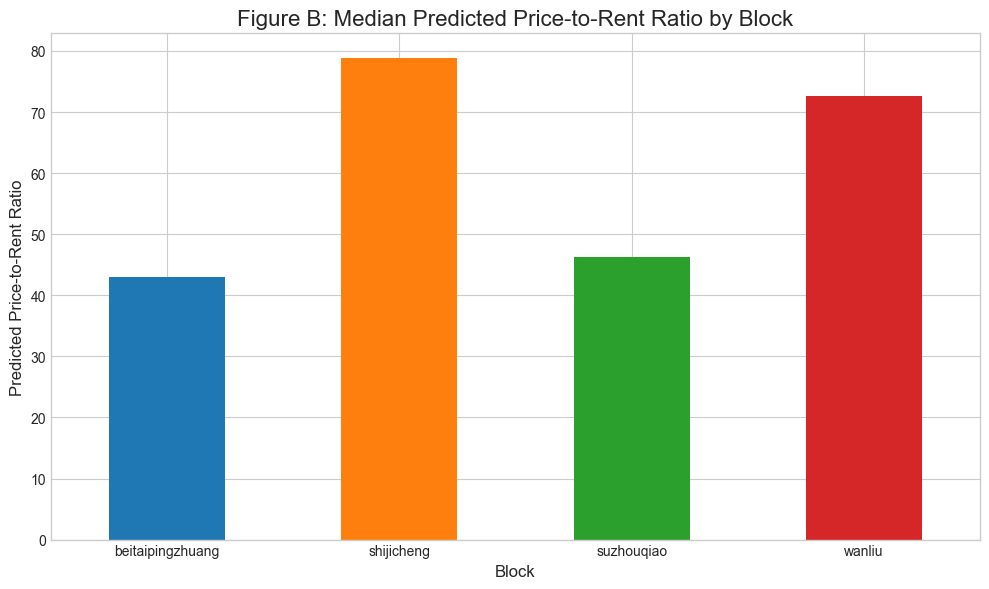

In [46]:
# --- Calculate Median Predicted Ratio for each Block ---
median_predicted_ratio = all_data_df.groupby('block')['predicted_ratio_years'].median().reset_index()
# --- Figure B: Bar Plot of Predicted Ratios ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

median_predicted_ratio.plot(kind='bar', x='block', y='predicted_ratio_years', ax=ax,
                            legend=False, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

ax.set_title('Figure B: Median Predicted Price-to-Rent Ratio by Block', fontsize=16)
ax.set_xlabel('Block', fontsize=12)
ax.set_ylabel('Predicted Price-to-Rent Ratio', fontsize=12)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# 3.5 Data Science Modeling Pro Max

In [64]:

# --- Models 1+ & 2+: Use Piecewise Functions (B-Splines) and Interaction ---
# includes the spline terms, block terms, and their interaction.
formula_plus = 'price_per_m2 ~ bs(area, df=4) * C(block)'

# --- Price Model ---
y_price, X_price_plus = dmatrices(formula_plus, data=all_prices_df, return_type='dataframe')
price_model_plus = sm.OLS(y_price, X_price_plus).fit()

# --- Rent Model ---
formula_rent_plus = formula_plus.replace('price_per_m2', 'rent_per_m2')
y_rent, X_rent_plus = dmatrices(formula_rent_plus, data=all_rents_df, return_type='dataframe')
rent_model_plus = sm.OLS(y_rent, X_rent_plus).fit()


In [51]:

# --- R-squared Comparison ---
print("--- R-squared Comparison ---")
print(f"Model 1 (Price) R-squared:           {price_model.rsquared:.4f} | Adj. R-squared: {price_model.rsquared_adj:.4f}")
print(f"Model 1+ (Price Pro Max) R-squared:  {price_model_plus.rsquared:.4f} | Adj. R-squared: {price_model_plus.rsquared_adj:.4f}\n")

print(f"Model 2 (Rent) R-squared:            {rent_model.rsquared:.4f} | Adj. R-squared: {rent_model.rsquared_adj:.4f}")
print(f"Model 2+ (Rent Pro Max) R-squared:   {rent_model_plus.rsquared:.4f} | Adj. R-squared: {rent_model_plus.rsquared_adj:.4f}")

--- R-squared Comparison ---
Model 1 (Price) R-squared:           0.6254 | Adj. R-squared: 0.6250
Model 1+ (Price Pro Max) R-squared:  0.7282 | Adj. R-squared: 0.7266

Model 2 (Rent) R-squared:            0.2622 | Adj. R-squared: 0.2614
Model 2+ (Rent Pro Max) R-squared:   0.4007 | Adj. R-squared: 0.3976

Models 1+ and 2+ (with splines) may have higher R-squared because they capture non-linear relationships more flexibly than a simple quadratic term.


Models 1+ and 2+ (with splines) may have higher R-squared because they capture non-linear relationships more flexibly than a simple quadratic term.

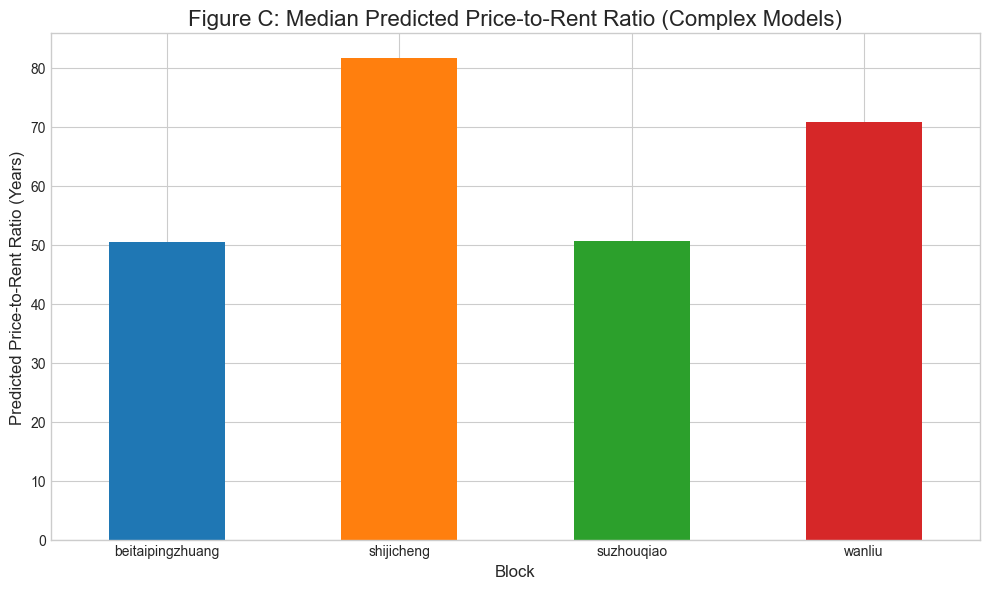

In [80]:
# 1) Fit Models 1+ and 2+ with fixed spline bounds (avoid out-of-bounds at predict time)
#    Use the global min/max of 'area' across all datasets.
area_min = pd.concat([all_prices_df['area'], all_rents_df['area'], all_data_df['area']]).min()
area_max = pd.concat([all_prices_df['area'], all_rents_df['area'], all_data_df['area']]).max()

formula_price_plus = (
    f"price_per_m2 ~ bs(area, df=4, lower_bound={area_min}, upper_bound={area_max}) * C(block)"
)
y_price, X_price_plus = dmatrices(formula_price_plus, data=all_prices_df, return_type='dataframe')
price_model_plus = sm.OLS(y_price, X_price_plus).fit()

# Rent Pro Max (Model 2+): same spline settings for rent
formula_rent_plus = formula_price_plus.replace('price_per_m2', 'rent_per_m2')
y_rent, X_rent_plus = dmatrices(formula_rent_plus, data=all_rents_df, return_type='dataframe')
rent_model_plus = sm.OLS(y_rent, X_rent_plus).fit()

# 2) Predict on the unified grid (all_data_df) using the training design_info
#    This ensures identical spline basis (knots + bounds) during prediction.
X_pred_price = build_design_matrices([X_price_plus.design_info], all_data_df, return_type='dataframe')[0]
X_pred_rent  = build_design_matrices([X_rent_plus.design_info],  all_data_df, return_type='dataframe')[0]

X_pred_price = X_pred_price.reindex(columns=X_price_plus.columns, fill_value=0)
X_pred_rent  = X_pred_rent.reindex(columns=X_rent_plus.columns,  fill_value=0)

# 3) Predict price/rent per m2 and compute price-to-rent ratio in years for each record
all_data_df['predicted_price_plus'] = price_model_plus.predict(X_pred_price)
all_data_df['predicted_rent_plus']  = rent_model_plus.predict(X_pred_rent)
all_data_df['predicted_ratio_plus_years'] = (
    all_data_df['predicted_price_plus'] / (all_data_df['predicted_rent_plus'] * 12.0)
)

# 4) Aggregate to median ratio by block (for Figure C)
median_predicted_ratio_plus = (
    all_data_df.groupby('block', as_index=False)['predicted_ratio_plus_years'].median()
)

# 5) Draw plot (Figure C) — stop here as requested
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
median_predicted_ratio_plus.plot(
    kind='bar', x='block', y='predicted_ratio_plus_years', ax=ax,
    legend=False, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
)
ax.set_title('Figure C: Median Predicted Price-to-Rent Ratio (Complex Models)', fontsize=16)
ax.set_xlabel('Block', fontsize=12)
ax.set_ylabel('Predicted Price-to-Rent Ratio (Years)', fontsize=12)
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

In [83]:

# --- Comparison of the Three Methods ---
# Method 1 results (from Figure A)
method1_results = price_rent_ratio_df.rename(columns={'price_rent_ratio_years': 'Method 1 (Direct Median)'})

# Method 2 results (from Figure B)
method2_results = median_predicted_ratio.rename(columns={'predicted_ratio_years': 'Method 2 (Simple Model)'})

# Method 3 results (from Figure C)
method3_results = median_predicted_ratio_plus.rename(columns={'predicted_ratio_plus_years': 'Method 3 (Complex Model)'})

# Merge results for comparison
comparison_df = pd.merge(method1_results, method2_results, on='block')
comparison_df = pd.merge(comparison_df, method3_results, on='block')

print("\n--- Comparison of Price-to-Rent Ratios (Years) from Three Methods ---")
print(comparison_df.to_string(index=False))


--- Comparison of Price-to-Rent Ratios (Years) from Three Methods ---
           block  Method 1 (Direct Median)  Method 2 (Simple Model)  Method 3 (Complex Model)
beitaipingzhuang                 51.334644                43.003136                 50.424015
      shijicheng                 85.460005                78.925802                 81.753279
      suzhouqiao                 54.031145                46.262551                 50.716584
          wanliu                 80.629791                72.591895                 70.878626


### Which to trust? (Cross Validation Method)


In [88]:
# Cross-validation to compare the three methods
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def pred_m1(train_df, df, ycol):
    gmed = train_df[ycol].median()
    bmed = train_df.groupby('block')[ycol].median()
    return df['block'].map(bmed).fillna(gmed).values

def pred_m2(train_df, df, ycol):
    mdl = smf.ols(f"{ycol} ~ area + C(block)", data=train_df).fit()
    return mdl.predict(df).values

def pred_m3(train_df, df, ycol, area_min, area_max):
    formula = f"{ycol} ~ bs(area, df=4, lower_bound={area_min}, upper_bound={area_max}) * C(block)"
    y_tr, X_tr = dmatrices(formula, data=train_df, return_type='dataframe')
    mdl = sm.OLS(y_tr, X_tr).fit()
    X_df = build_design_matrices([X_tr.design_info], df, return_type='dataframe')[0]
    X_df = X_df.reindex(columns=X_tr.columns, fill_value=0)
    return mdl.predict(X_df).values

def eval_target_train_test_rmse(df, ycol, kf, area_min, area_max):
    df = df.dropna(subset=['area', ycol, 'block']).reset_index(drop=True)
    models = {
        'M1': lambda tr, de: pred_m1(tr, de, ycol),
        'M2': lambda tr, de: pred_m2(tr, de, ycol),
        'M3': lambda tr, de: pred_m3(tr, de, ycol, area_min, area_max),
    }
    train_rmse = {k: [] for k in models}
    test_rmse  = {k: [] for k in models}

    for tr_idx, te_idx in kf.split(df):
        tr, te = df.iloc[tr_idx].copy(), df.iloc[te_idx].copy()

        for name, fn in models.items():
            # Calculate RMSE on train and test sets
            y_tr_true = tr[ycol].values
            y_tr_pred = fn(tr, tr)
            train_rmse[name].append(rmse(y_tr_true, y_tr_pred))
            y_te_true = te[ycol].values
            y_te_pred = fn(tr, te)
            test_rmse[name].append(rmse(y_te_true, y_te_pred))

    out = pd.DataFrame({
        'Train_RMSE': {k: float(np.mean(v)) if len(v) else np.nan for k, v in train_rmse.items()},
        'Test_RMSE':  {k: float(np.mean(v)) if len(v) else np.nan for k, v in test_rmse.items()},
    }).loc[['M1','M2','M3']]
    return out

def cross_validate_train_test_errors(all_prices_df, all_rents_df, n_splits=5, random_state=42):
    area_min = pd.concat([all_prices_df['area'], all_rents_df['area']]).min()
    area_max = pd.concat([all_prices_df['area'], all_rents_df['area']]).max()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    price_res = eval_target_train_test_rmse(all_prices_df, 'price_per_m2', kf, area_min, area_max)
    rent_res  = eval_target_train_test_rmse(all_rents_df,  'rent_per_m2',  kf, area_min, area_max)

    print("\nPrice per m² — Train/Test RMSE:")
    print(price_res.round(3))
    print("\nRent per m² — Train/Test RMSE:")
    print(rent_res.round(3))

cross_validate_train_test_errors(all_prices_df, all_rents_df, n_splits=5, random_state=42)


Price per m² — Train/Test RMSE:
    Train_RMSE  Test_RMSE
M1   31322.879  31313.995
M2   26338.510  26386.335
M3   22397.668  23957.181

Rent per m² — Train/Test RMSE:
    Train_RMSE  Test_RMSE
M1      55.884     55.836
M2      50.025     50.129
M3      45.083     45.260


(1) For a sufficiently large sample size, Method 3 (Complex Model) is generally more trustworthy because it provides a more nuanced model of complex real-world relationships.

(2) However, if the sample size is small, the complex model risks overfitting (fitting to noise), in which case Method 2 (Simple Model) might be a more robust choice.

In our cross-validation results, the third method(complex model) shows the lowest test RMSE for both price and rent predictions. So, we can trust Method 3 the most in this dataset.